TFs downloaded form [tfcheckpoint](https://www.tfcheckpoint.org/)

In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
data_path = "data/"
check_path = "checkpoints/"

# os.makedirs(check_path)

os.chdir("../")
print(os.getcwd())

/Users/flynnzhang/CMU/Spring24/02620-ML4Scientists/scRNA-seq_ML


In [3]:
# load all combined data
all_adata = sc.read_h5ad(check_path + 'combined_labeled.h5ad')

all_adata

AnnData object with n_obs × n_vars = 23873 × 19724
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells'
    uns: 'log1p'
    layers: 'counts'

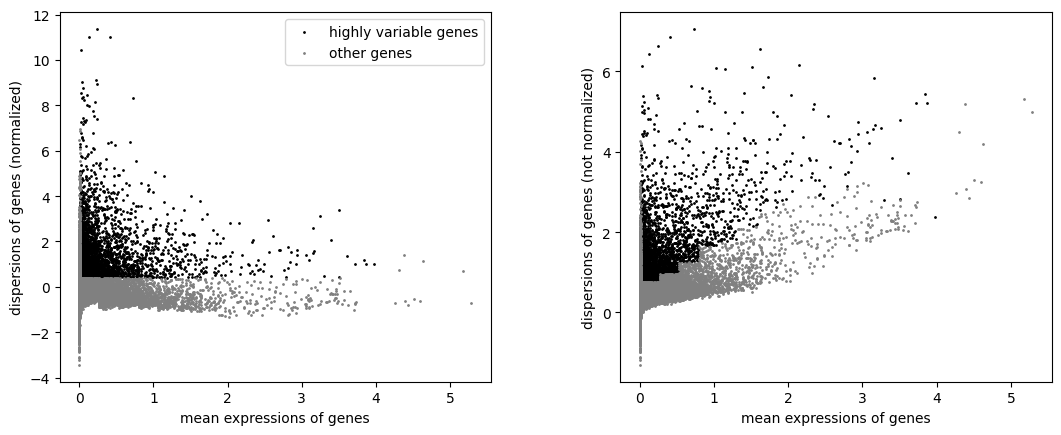

In [4]:
# get the highly variable genes
sc.pp.highly_variable_genes(all_adata, min_mean=0.01, max_mean=4, min_disp=0.4)
sc.pl.highly_variable_genes(all_adata)

In [5]:
# subset the data to only include the highly variable genes
filtered_adata = all_adata[:, all_adata.var.highly_variable]

filtered_adata

View of AnnData object with n_obs × n_vars = 23873 × 3133
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [6]:
filtered_adata.obs.cell_types.value_counts()

cell_types
immune cells          10372
fibroblasts            9046
epithelial cells       3181
endothelial cells      1039
smooth muscle cell      235
Name: count, dtype: int64

In [9]:
# subset data to only include cells from the first 3 clusters
cell_types_of_interest = ['epithelial cells']

adata_subset = filtered_adata[filtered_adata.obs.cell_types.isin(cell_types_of_interest)].copy()

In [10]:
adata_subset

AnnData object with n_obs × n_vars = 3181 × 3133
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch', 'kmeans_clusters', 'cell_types'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [10]:
# use combat to correct for batch effects and rule out unwanted sources of variation
sc.pp.combat(adata_subset, key='batch', covariates=['total_counts'])

# scale each gene to unit variance, clip values exceeding SD 10
sc.pp.scale(adata_subset, max_value=10)

Found 114 genes with zero variance.


/Users/flynnzhang/anaconda3/envs/seq/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: invalid value encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/Users/flynnzhang/anaconda3/envs/seq/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


# Regression

#### List of cell types that are worth exploring:
- Immune cells
- Fibroblasts
- Endothelial cells
- Epithelial cells

In [11]:
# load all tfs
tfs = pd.read_csv(data_path + "TFs/tfs.txt", sep="\t")

tfs

,Gene_symbol,Gene_Name,Synonyms,Human_entrez,Mouse_entrez,Rat_entrez
0,A430033K04Rik,-,-,NaN,243308.0,304336.0
1,AASS,"Alpha-aminoadipic semialdehyde synthase, mitoc...",LORSDH LKRSDH,10157.0,NaN,NaN
2,AATF,Protein AATF,DED CHE-1 CHE1 BFR2,26574.0,56321.0,114512.0
3,ABL1,Tyrosine-protein kinase ABL1,JTK7 c-ABL p150,25.0,11350.0,100909750.0
4,ABRA,Actin-binding Rho-activating protein,STARS,137735.0,223513.0,286965.0
...,...,...,...,...,...,...
3549,ZXDA,Zinc finger X-linked protein ZXDA,ZNF896,7789.0,668166.0,NaN
3550,ZXDB,Zinc finger X-linked protein ZXDB,ZNF905,158586.0,668166.0,NaN
3551,ZXDC,Zinc finger protein ZXDC,MGC11349 FLJ13861,79364.0,80292.0,362399.0
3552,ZYX,Zyxin,-,7791.0,NaN,NaN


In [12]:
# we need mouse tfs
TFs_mouse = tfs[tfs['Mouse_entrez'].notna()]['Gene_symbol'].values
TFs_mouse = [x for x in TFs_mouse if x in adata_subset.var_names]

print('Total genes:', len(adata_subset.var_names))
print('Total present TFs:', len(TFs_mouse))

Total genes: 3488
Total present TFs: 7


## Ridge, Lasso, and ElasticNet

In [13]:
import statsmodels.api as sm

# 'TFs_mouse': list of TFs in mouse
def OLS(adata, tf_list):
    results = {}
    
    for tf in tf_list:
        print('Fitting model for', tf)
        Y = adata[:, tf].X
        X = adata.X[:, ~adata.var_names.isin([tf])] # remove the TF from the gene list
        X = sm.add_constant(X) # add constant term

        model = sm.OLS(Y, X)
        results[tf] = model.fit() # save the results for each model
        
    return results

OLS_res = OLS(adata_subset, TFs_mouse)

TFs: dict_keys(['Basp1', 'Csprs', 'Cys1', 'Fgf2', 'Ppp1r15a', 'Rhox5', 'Trib2'])


/Users/flynnzhang/anaconda3/envs/seq/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


R-squared: [0.8356223831186984, 0.7439625499234976, nan, 0.6339430552099516, 0.7761295501311647, 0.6861198700021979, 0.855462197872475]


In [21]:
# see the results
print('TFs:', OLS_res.keys())
# print all r-squared values
print('R-squared:', [OLS_res[tf].rsquared for tf in OLS_res.keys()])
print('Adj. R-squared:', [OLS_res[tf].rsquared_adj for tf in OLS_res.keys()])
print('MSE:', [OLS_res[tf].mse_resid for tf in OLS_res.keys()])

TFs: dict_keys(['Basp1', 'Csprs', 'Cys1', 'Fgf2', 'Ppp1r15a', 'Rhox5', 'Trib2'])
R-squared: [0.8356223831186984, 0.7439625499234976, nan, 0.6339430552099516, 0.7761295501311647, 0.6861198700021979, 0.855462197872475]
Adj. R-squared: [0.6915827955774483, 0.5196039699426, nan, 0.31317741603997196, 0.5799580282805565, 0.41107533948728747, 0.7288076946769382]
MSE: [0.3084172044225512, 0.43433724947267477, 0.0, 0.5233397758914349, 0.42004197171944535, 0.0203110663533905, 0.26584330522053096]


In [15]:
# save results
import pickle

with open(check_path + 'OLS_res.pkl', 'wb') as f:
    pickle.dump(OLS_res, f)

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def regression(adata, tf_list, method='linear', test_size=0.2, random_state=42):
    results = {}
    scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance
    print(f"Running {method} regression")
    
    for tf in tf_list:
        print(f"Processing {tf}")
        try:
            Y = adata[:, tf].X
            X = adata.X[:, ~adata.var_names.isin([tf])]
            X = scaler.fit_transform(X) # standardize the data
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

            if method == 'linear':
                model = LinearRegression()
            elif method == 'ridge':
                model = Ridge()
            elif method == 'lasso':
                model = Lasso()
            elif method == 'elastic':
                model = ElasticNet()

            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            results[tf] = {
                'model': model,
                'R2': r2_score(Y_test, Y_pred),
                'MSE': mean_squared_error(Y_test, Y_pred)
            }

        except Exception as e:
            print(f"Error processing {tf}: {str(e)}")
            results[tf] = None
        
    return results


In [18]:
test_size = 0.2
random_state = 42

linear_res = regression(adata_subset, TFs_mouse, method='linear', test_size=test_size, random_state=random_state)
# ridge_res = regression(adata_subset, TFs_mouse, method='ridge', test_size=test_size, random_state=random_state)
# lasso_res = regression(adata_subset, TFs_mouse, method='lasso', test_size=test_size, random_state=random_state)
# elastic_res = regression(adata_subset, TFs_mouse, method='elastic', test_size=test_size, random_state=random_state)

Running linear regression
Processing Basp1
Processing Csprs
Processing Cys1
Processing Fgf2
Processing Ppp1r15a
Processing Rhox5
Processing Trib2


In [20]:
for tf, res in linear_res.items():
    print(f"{tf}: R2={res['R2']:.2f}, MSE={res['MSE']:.2f}")

Basp1: R2=-45359900992594864.00, MSE=45279969748060952.00
Csprs: R2=-11204339846397016064.00, MSE=10366142465458640896.00
Cys1: R2=1.00, MSE=0.00
Fgf2: R2=-7940526447501865984.00, MSE=5852367828370063360.00
Ppp1r15a: R2=-1896271859760847104.00, MSE=1860323973606500352.00
Rhox5: R2=-17832449707675186364416.00, MSE=124387671119107817472.00
Trib2: R2=-532545314513181736960.00, MSE=482731033445482758144.00


In [19]:
# print R2, MSE for each TF of all models
for name, result in zip(['Linear', 'Ridge', 'Lasso', 'ElasticNet'], [linear_res, ridge_res, lasso_res, elastic_res]):
    print(f"{name} regression")
    for tf, res in result.items():
        print(f"{tf}: R2={res['R2']:.2f}, MSE={res['MSE']:.2f}")

NameError: name 'ridge_res' is not defined

In [16]:
# Save the results
import pickle

for res, method in zip([linear_res, ridge_res, lasso_res, elastic_res], ['linear', 'ridge', 'lasso', 'elastic']):
    with open(check_path + f'regression_{method}.pkl', 'wb') as f:
        pickle.dump(res, f)